# Total Load Forecast in Switzerland

This projects takes data from the European Network of Transmission System [for electricity], where you can request an API Key from.

This project tries to forecast the total load of Switzerland on a weekahead basis.

## Data Collection

This project makes use of [entsoe-py](https://github.com/EnergieID/entsoe-py) to load the data directly into pandas frame.

In [136]:
import os
from entsoe import EntsoePandasClient
import pandas as pd
from dotenv import load_dotenv

load_dotenv()
API_KEY = os.environ.get('API_KEY')

client = EntsoePandasClient(api_key=API_KEY)

start = pd.Timestamp('20191101', tz='Europe/Zurich')
end = pd.Timestamp('20211107', tz='Europe/Zurich')
country_code = 'CH'

df = client.query_load_and_forecast(country_code, start=start, end=end)

changing the dataframe so there is an index column and the timestamp becomes column with name time.

In [137]:
df = df.rename_axis('time')
df = df.tz_localize(None)
df.reset_index(inplace=True)

In [138]:
df

,time,Forecasted Load,Actual Load
0,2019-11-01 00:00:00,6711.0,6194.0
1,2019-11-01 01:00:00,6313.0,6272.0
2,2019-11-01 02:00:00,6312.0,6384.0
3,2019-11-01 03:00:00,6312.0,6563.0
4,2019-11-01 04:00:00,6309.0,6657.0
...,...,...,...
17678,2021-11-06 19:00:00,7657.0,7878.0
17679,2021-11-06 20:00:00,7584.0,7610.0
17680,2021-11-06 21:00:00,7528.0,7195.0
17681,2021-11-06 22:00:00,7332.0,7305.0


## Data Cleaning

Since there are missing values in the data set, namely missing timestamps which most likely were not recorded we are filling them up with the ffill method same values as previous once.

In [139]:
start_timestamp = pd.Timestamp('20191101')
end_timestamp = pd.Timestamp('20211107')

df_ts = pd.DataFrame(pd.date_range(start=start_timestamp, end=end_timestamp, freq='1H')[:-1], columns=['time'])
df_cleaned = pd.merge(df_ts, df.drop_duplicates(subset='time'), on='time', how='left').fillna(method='ffill')

## Data Processing

Looking at the actual total load from 01.11.19 until 07.11.21.

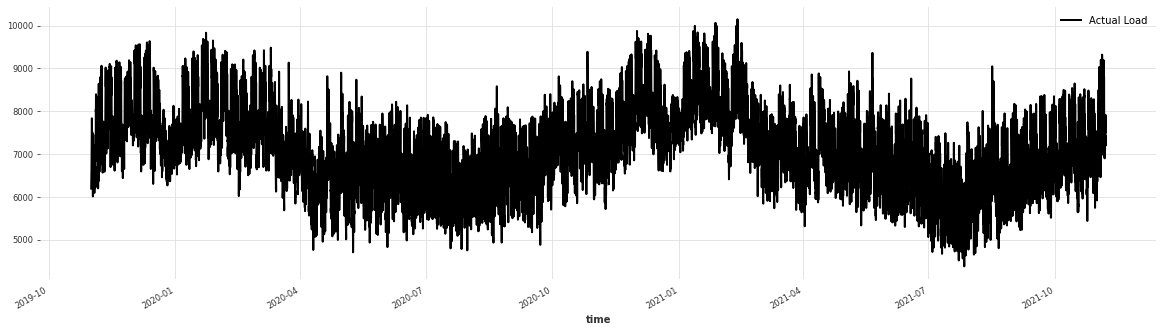

In [140]:
from darts import TimeSeries
import matplotlib.pyplot as plt

series = TimeSeries.from_dataframe(df_cleaned, 'time', 'Actual Load')
plt.figure(figsize=(20,5))
series.plot()

Splitting up the data into 2 years of training data and 7 day [weekahead forecast]

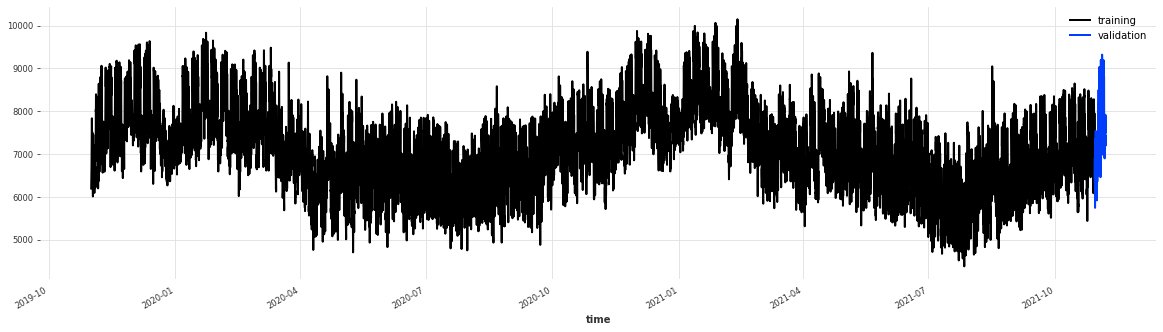

In [141]:
training, validation = series.split_before(pd.Timestamp('20211030'))
plt.figure(figsize=(20,5))
training.plot(label='training')
validation.plot(label='validation')

## Classical models

Currently calculating Linear Regression Model
Currently calculating Random Forest Model
Currently calculating Exponential Smoothing


/Users/Jorit/Projects/energy-systems-iot/.venv/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Currently calculating ARIMA


/Users/Jorit/Projects/energy-systems-iot/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Currently calculating AutoARIMA


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Currently calculating Prophet


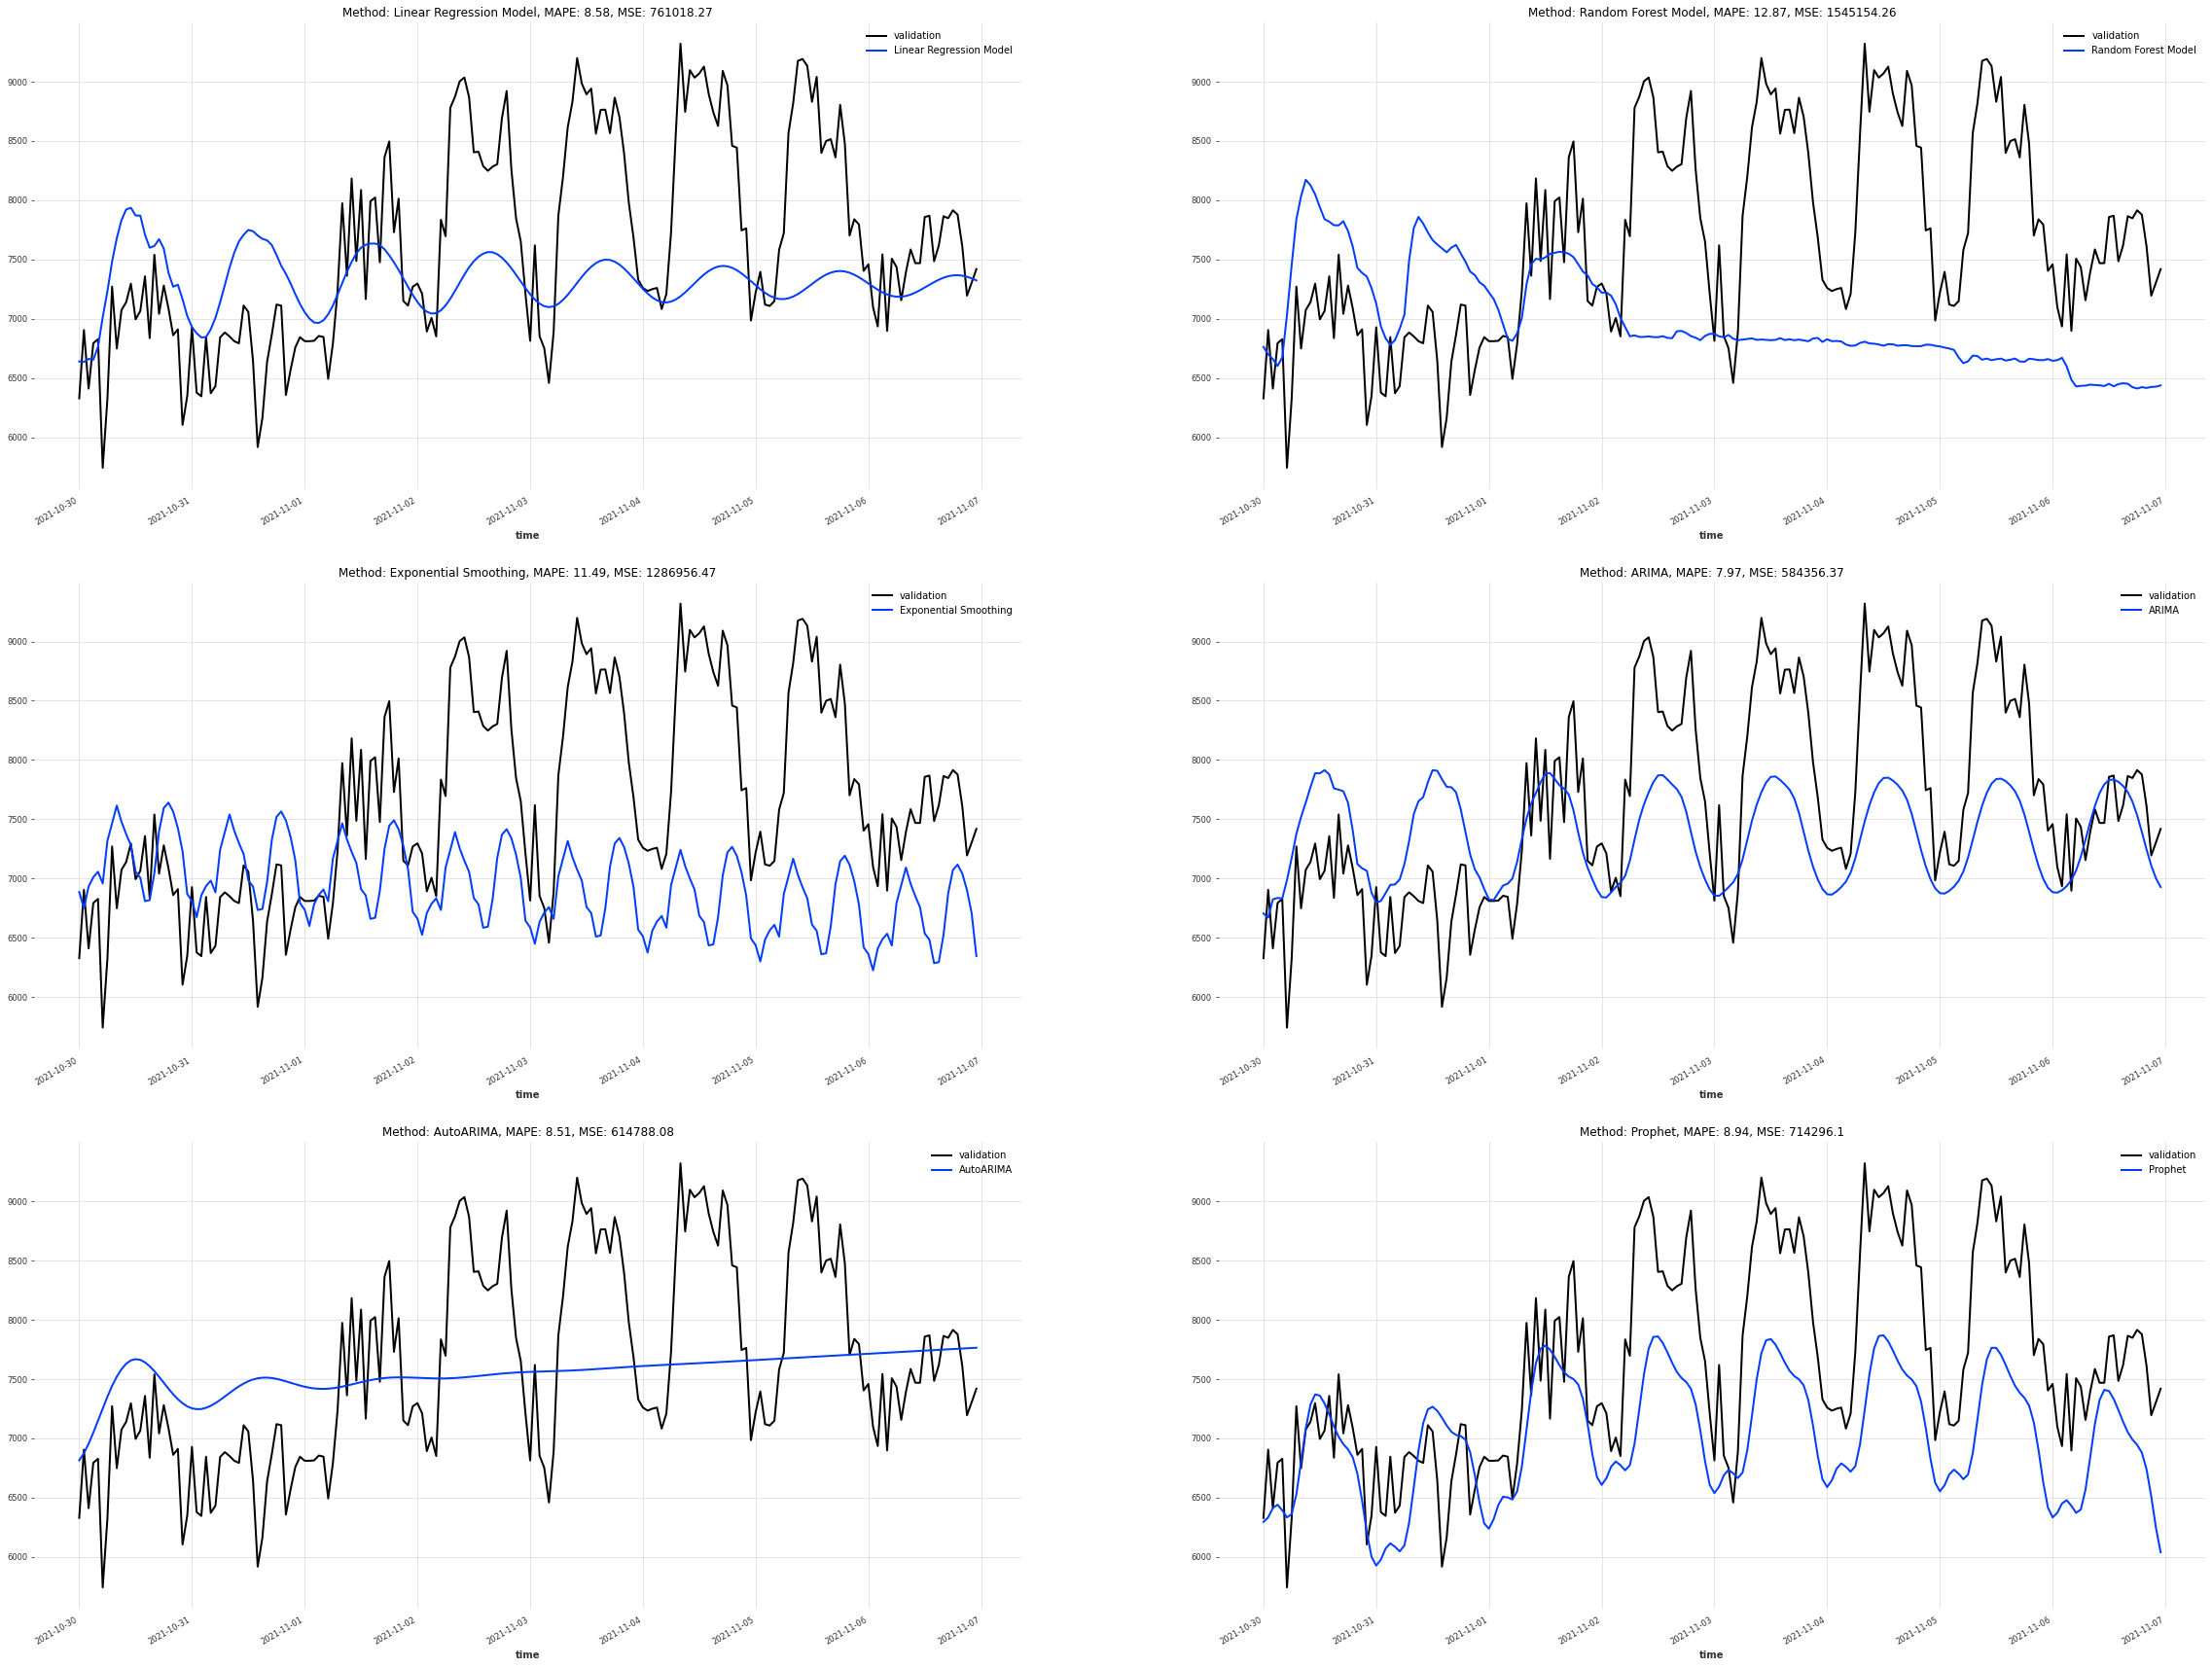

In [181]:
from darts.models import LinearRegressionModel, RandomForest, ExponentialSmoothing, ARIMA, AutoARIMA, Prophet
from darts.metrics import mape, mse

# since we are using hourly data it makes sense to use the last 24 hours [lags] to predict the next value
model0 = LinearRegressionModel(lags=24)
model1 = RandomForest(lags=24, n_estimators=300) # don't really know what's a sensible number for amount of trees here, just chose 300
model2 = ExponentialSmoothing(seasonal_periods=24)
model3 = ARIMA(p=12, d=1, q=24)
model4 = AutoARIMA()
model5 = Prophet()

models = {
    "Linear Regression Model" : model0,
    "Random Forest Model" : model1,
    "Exponential Smoothing" : model2,
    "ARIMA" : model3,
    "AutoARIMA" : model4,
    "Prophet" : model5
}

fig = plt.figure(figsize=(40, 30))
for i, (name, model) in enumerate(models.items()):
    print(f"Currently calculating {name}")
    model.fit(series=training)
    predictions = model.predict(n=len(validation))
    mape_score = round(mape(validation, predictions), 2)
    mse_score = round(mse(validation, predictions), 2)

    # plotting figure
    fig.add_subplot(3, 2, i+1)
    #training.plot(label="training")
    validation.plot(label="validation")
    predictions.plot(label=name)
    plt.title(f"Method: {name}, MAPE: {mape_score}, MSE: {mse_score}")
    plt.legend()
# fig.tight_layout()
plt.show()